In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#GlobalFinMonthly
url="https://raw.githubusercontent.com/amoreira2/Lectures/main/assets/data/GlobalFinMonthly.csv"
Data = pd.read_csv(url,na_values=-99)
Data['Date']=pd.to_datetime(Data['Date'])
Data=Data.set_index(['Date'])
Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })


# Trading Strategies

* A trading strategy is a procedure that maps any information known up to time t, into a set of trading instructions for time  $T>t$.

   - the mean-variance analysis we did so far was **not** a valid trading strategy: 
   - we used data of the whole sample to estimate the weights of our strategy and evaluated the strategy in the same sample



* It is very important that the trading strategy only uses information that is known at the time of the trade-- you obviously cannot trade on info that you don't know

* The weights of a trading strategy must either:
   * Add up to 1. So it describes what you do with your entire capital.
   * Or add up to 0. So the strategy is self-financing. For example, borrow 1 dollar at the risk-free rate and buy 1 dollar worth of the market portfolio
   * Every time you trade on the excess returns, you can think of the weights "adding up to zero", because it is a long-short portfolio.
   * In practice all strategies demand some capital as no bank allow us to borrow without putting some capital in, but these self financed strategies are quite convenient to work with as they are all in the "Excess Return Space" since they have zero cost. 

**Examples**

* Example of a VALID trading strategy: Every monday buy stocks that had positive news coverage during the weekend and sell stocks that had negative news coverage.

  * This is valid because you are trading after the information is known.

* Example of INVALID trading strategy: On Friday buy all the stocks that WILL have positive news coverage during the weekend, and sell all the stocks that WILL have negative coverage during the weekend.

   * This is Invalid because you are trading before the information is known.
   
* This might sound ridiculous. Obviously you cannot trade on the information that is not known at the time of the trade!


**Types of trading strategies**

- **Strategic allocation**: How you allocate across broad asset classes: Cash, Equities (US, Developed Markets, Emerging Markets), Government bonds (US, ...), Corporate bonds(US, ...), Commodities, Private equity, real assets (land,...)

    -  The strategy takes positions on broader asset classes. For example pension funds tend to follow a 70-30 split between equity and bonds
    -  An example is of this is the mean-variance anaylsis we did last few chapters.
    -  We will revisit this here but now making the analysis more tight
    -  Another example is RISK-PARITY which we will discuss later 
    

- **Timing**: Easier to think in terms of one risky asset and cash. The strategy basically goes in and out of an asset according to some model that forecasts time-variaiton either in returns of the risky asset realitve to cash or in it's riskness

    - You obvioulsy can time multiple things at the same time, but it is useful separation to help understand what the strategy is doing
    
- **Cross-sectional** (within asset class): This is about how you invest within an asset class. The "defaul" option is to do a market-cap weighted portfolio which we will discuss below. The cross-sectional strategies use some information to deviate from the market portfolio in the asset class

    - The are cross-sectional strategies everywhere: equities, gov bonds, corp bonds, futures, equity indexes, currencies, commodities, options, crypto currrencies
    - All these asset classes have lots of data and are naturally a good place to do quantitative investing
    - For this class we focus on equities

- Strategies can be discretionary: A team decides to place a trade based on their evaluation of information about a firm or the macro environment


- Strategies can be systematic: they can be codified. Explicit rule for the portfolio based on some hard data. Systematic trading strategies are often called **Quantitative**




## **Quantitative trading strategies**

* A quant trading strategy get some hard data about one or multiple assets and transform this data  into  portfolio weights

* So given data $Z_{t}$ ( potentially a very big vector), a quantitative trading strategy is a function that maps data into weights $X_{t+1}=f(Z_t)$


## **Our First Quantitative Strategy**

 
Here what we will do: do the mean-variance analysis assuming I am an investor that is doing this in real time

- so I will say the investor will start in 1973, 10 years after the beginning of the sample 
- simply use the past data to estimate the means and covariances,
- compute the weights and invest on the assets according to this strategy for the next month.
 
I will do that for the entire sample.
 
This will be valid because at no moment We will use information that an investor would not have had available in real time. 


We will target an annual volatility of 15%

We will start by using just the first 10 years and evaluating on the rest of the sample as a warm up (because it is simpler)


Warm up

In [6]:
# construct excess returns from our data

Re=(Data.drop('RF',axis=1)).subtract(Data['RF'],axis='index')
Re.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 647 entries, 1963-02-28 to 2016-12-31
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MKTUS    647 non-null    float64
 1   BondUS   647 non-null    float64
 2   EM       647 non-null    float64
 3   MKTxUS   647 non-null    float64
 4   BondxUS  646 non-null    float64
dtypes: float64(5)
memory usage: 30.3 KB


In [22]:
# lets start by redoing our full sample analysis

# create a dataframe to store results
Results=pd.DataFrame([],index=[])
#Estimate moments using full sample

ERe=Re.mean()
CovRe=Re.cov()
# Set desired volatility and convert to monthly units
Targetvol=0.15/(12**0.5)


# construct weights and normalize them so the have desired volatility
X=np.linalg.inv(CovRe) @ ERe* (Targetvol/(ERe @ np.linalg.inv(CovRe) @ ERe)**0.5)
#store results for full sample
Results.at['avgreturn','Fullsample']=X @ ERe*12
Results.at['volatility','Fullsample']=(X @ CovRe @ X*12)**0.5
Results.at['shaperatio','Fullsample']=(X @ ERe*12)/((X @ CovRe @ X*12)**0.5)

Results

,Fullsample
avgreturn,0.085055
volatility,0.150000
shaperatio,0.567030


In [23]:

#Estimate moments up to 1973
Endofsample=1987
ERe=Re[:str(Endofsample)].mean()
CovRe=Re[:str(Endofsample)].cov()

# construct weights and normalize them so the have desired volatility
X=np.linalg.inv(CovRe) @ ERe* (Targetvol/(ERe @ np.linalg.inv(CovRe) @ ERe)**0.5)

# store results for estimation period
Results.at['avgreturn','Estimation_pre'+str(Endofsample)]=X @ ERe*12
Results.at['volatility','Estimation_pre'+str(Endofsample)]=(X @ CovRe @ X*12)**0.5
Results.at['shaperatio','Estimation_pre'+str(Endofsample)]=(X @ ERe*12)/((X @ CovRe @ X*12)**0.5)

# construct time series of returns for out of sample period
Rp=Re[str(Endofsample+1):] @ X

# store results for out of sample period
Results.at['avgreturn','test_pos'+str(Endofsample)]=Rp.mean()*12
Results.at['volatility','test_pos'+str(Endofsample)]=Rp.std()*12**0.5
Results.at['shaperatio','test_pos'+str(Endofsample)]=Rp.mean()*12/(Rp.std()*12**0.5)


Results

,Fullsample,Estimation_pre1987,test_pos1987
avgreturn,0.085055,0.077184,0.059583
volatility,0.150000,0.150000,0.208493
shaperatio,0.567030,0.514557,0.285780


- Look how bad this is
- The average excess return ends up negative!
- The volatility ends up as much twice as large

Why so bad? What is going on?

* We stopped in 1973. MAybe 10 years is not enough. 
* maybe we should split test sample and estimation sample more evenly? 
* what happens if we split right down the middle? Are the results better? Are they good enough?

A more sophisticated and also more realistic description of a trading strategy uses the concept of a rolling estimation sample

Basically you start in some date 1973, build you portfolio and hold it for a month, and each month that passes you re-estimate your weights and again hold the new portfolio for another month

So you are always using data up to month t and holding the position in date t+1.





In [27]:

Rp=pd.Series([],index=[],dtype=float)

# I will start building portfolios in the end of 1972 so my first return will be january 1973 
# and will use data up do december 1972
for date in Re['1973-1':].index:
    # I am using DateOffset function to tell python to stop on month before 
    # so the estimation sample will be all months up to one month before the return that I 
    #I will be trading
    # this guarantees the strategy is VALID with respect to information
    ERe=Re[:date- pd.DateOffset(months=1)].mean()
    CovRe=Re[:date- pd.DateOffset(months=1)].cov()
# construct weights and normalize them so the have desired volatility
    X=np.linalg.inv(CovRe) @ ERe* (Targetvol/(ERe @ np.linalg.inv(CovRe) @ ERe)**0.5)
    #store the strategy returns of the relevant month
    Rp.at[date]=X @ Re.loc[date]

# store results for out of sample period
Results.at['avgreturn','test_rolling']=Rp.mean()*12
Results.at['volatility','test_rolling']=Rp.std()*12**0.5
Results.at['shaperatio','test_rolling']=Rp.mean()*12/(Rp.std()*12**0.5)

Results

,Fullsample,Estimation_pre1987,test_pos1987,test_rolling
avgreturn,0.085055,0.077184,0.059583,0.063920
volatility,0.150000,0.150000,0.208493,0.181048
shaperatio,0.567030,0.514557,0.285780,0.353057


- How would you evaluate if this was a good strategy?

- It certainly way worse than the full sample? But is it good enough? Is it worth pursuing? 

- How to evaluate it?

## Garbage in, Garbage out

* we are plugging estimators for expected returns and the covariance matrix wihthout any evaluation if our procedure actually implements good estimators

* If our estimators are garbage, MV analysis will produce garbage

* Mean-variance optimization is EXTREMELY sensitive to the inputs
    1. Expected returns
    1. Covariance matrix: cross assets correlations and asset volatilities

* Importantly our estimators are extremely noisy--returns are very volatile

* assuming the underlying distribution is constant (big if), we need very long data set to reduce the uncertainty of our estimates for expected returns, and also to a lesser extent correlations and vols

### Estimation uncertainty

*  estimate the uncertainty regarding our average expected excess return estimates for each asset

*  show how the weights change as we change these estimates in a way that is consistent with the amount of uncertainty, i.e. those are alternative numbers that we could have estimated by change

*  show how sensitive the benefits of international diversification are

**Standard errors of average estimators**

* If observations are serially uncorrelated over time then the standard deviation of a sample average is simply

$$std\left(\sum_t^T\frac{R_t}{N}\right)=\frac{std(x_t)}{\sqrt{T}}$$


* This measures how uncertain we are about the sample mean

* For example, there is a 5% probability that the actual mean is $E[x_i]\leq\overline{R_t}-1.64{std(\overline{R_t})}$

* So $std(\overline{R_t})$ gives a measure of how close our estimate is likely to be to true expected value

* Lets compare the sample average and the sample average standard deviation for our assets

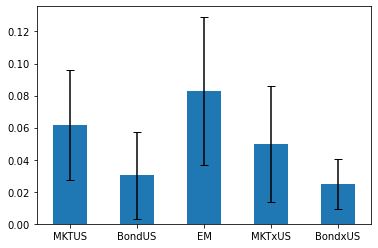

In [29]:
# First we get the total number of observations and store it as `T`
T=Re.shape[0]
# (1) standard deviation of the sample average of excess return for each asset
avg_std=(Re.std()/(T**0.5))*12

# (2) sample average of excess return for each asset
avg=Re.mean()*12


# report annualized and in percent
avg.plot.bar(yerr=avg_std*1.64,  capsize=4, rot=0);

- What happens if the sample was only 10 years?
- What happens if the assets is twice more volatile?
- What happens if you want to be be 99% sure to be right (instead of 68%)


## Sensitivity of optimal weights to uncertainty

- Lets revisit the classical financial advice that investors should have 60 in equities and 40 in bonds

- We will assume that the truth is 2 standard deviations below the mean for the US market

- We will them compare the expected return we expected to get, vs what we actually get


In [60]:


assets=['MKTUS','BondUS']

Weights_perturb=pd.DataFrame([],index=assets)
ERe=Re[assets].mean()
CovRe=Re[assets].cov()
T=Re.shape[0]

asset='MKTUS'
pertubation=2
mu=Re[asset].mean()
mu_std=Re[asset].std()/T**0.5
# I am creating a copy of the average return vector so I can pertubate it below 
ER_perturb=ERe.copy()
# so this will be the pertubated mean for asset MKTUS, which will represent the actual truth
ER_perturb[asset]=mu-pertubation*mu_std

# mve for sample mean
Weights_perturb.loc[:,'estimate'] =np.linalg.inv(CovRe) @ ERe
# mve for perturbed mean
Weights_perturb.loc[:,'truth'] =np.linalg.inv(CovRe) @ ER_perturb



We can then normalize the weights to achieve some desired volatility or that they add up to 1

Here I will simply make them add up to 1

In [64]:

#normalizing weights so they add up to 1
Weights_perturb=Weights_perturb/Weights_perturb.sum()
Weights_perturb

,estimate,truth
MKTUS,0.581072,0.272283
BondUS,0.418928,0.727717


- the `estimate` weights tell us the optimal weights given the data we saw
- the `truth` tell us the optimal weights given the true moments


We can now comapre the expected return that we expected to get (given the data) and the one we actually get (given the truth)


In [65]:
# Calculate the expression first
expected_data = Weights_perturb.loc[:,'estimate'] @ ERe * 12
# Then use the result in the f-string
print(f'Expected to get given data: {expected_data}')
# Calculate the expression first
actual_data = Weights_perturb.loc[:,'estimate'] @ ER_perturb * 12

# Then use the result in the f-string
print(f'Will actually get given the truth:{actual_data}')



Expected to get given data: 0.04852462499115859
Will actually get given the truth:0.02432653824907584


* What perturbation are we are exposed to?  that they true mean is higher or lower than expected?
* How does it depend on the weights?
* Why perturbing one assets leads to changes in the other assets? What this cross-sensitivity depends on?
* What do you think will happen if we do this with individual stocks instead? Why?
* what do you think would happen by adding crypto to this problem, say bitcoin?
* similar problems happen in estimating the correlations specially as the number of assets grow large


## Covariance estimation with a large cross-sectional of assets


* Lets import the universe of US equities
* The sample is 15 years. 

In [ ]:
import datetime as dt
import wrds
import psycopg2 
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
###################
# Connect to WRDS. #
# You will be required to put your name and password if you have it
###################
conn=wrds.Connection() 

###################
# This below dowloads from the server the data that we want #
###################
crsp_m = conn.raw_sql("""
                      select a.permno, a.date, b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc,a.retx
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/2005' and '12/31/2020'
                      and b.exchcd between 1 and 3
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 

# this saves it
#crsp_m.to_pickle('../../assets/data/crspm2005_2020.pkl')
# variables downloaded

# 1. Permno-- are unique indentifier to a security 
# (for exmaple a stock that has multiple types of stocks will have multiple permnos)

# 2. shrco is the type of share: common share, ADR, ETF, ....
# we will focus on common shares

# 3. exchcd is the code of the exchange where the stock was originally listed
# we will focus on stock listed in the 3 major stock exchanges ( basically the whole market)

# 4. ret,retx, shrout,  prc, are the stock return, the stock return excluding dividends, number of shares outstanding, and price

# 5. date is the trading date of the return



Enter your WRDS username [Alan.Moreira]: moreira5
Enter your password: ···········


WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


____
*If you don't want to deal with that you can simply get the data by running the code below*

In [ ]:

crsp_m=pd.read_pickle('https://github.com/amoreira2/Lectures/blob/main/assets/data/crspm2005_2020.pkl?raw=true')

In [78]:
from pandas.tseries.offsets import MonthEnd
# keep the variables we need
crsp=crsp_m[['permno','date','ret']].copy()
# change variable format to int
crsp[['permno']]=crsp[['permno']].astype(int)
# Line up date to be end of month 
crsp['date']=crsp['date']+MonthEnd(0)

In [80]:
crsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763626 entries, 0 to 763625
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   permno  763626 non-null  int32         
 1   date    763626 non-null  datetime64[ns]
 2   ret     759919 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 14.6 MB


In [85]:
# there are about 4 thousand stocks in the sample on average
print(759919/(15*12))

# but overall 8 thousand stocks traded in the sample
crsp.permno.unique().shape[0]

# why is that?

4221.772222222222


8386

- How many parameters do we need to estimate for a covariance matrix across these 8 thousand stocks?
- Do we even have enough observations for that?
- What will happen with our covariance matrix?



Lets just try and see what happens

We will do brute force
1. Set permno and date as indexes
1. unstack so we have the different firms in the columns and the dates in the rows


In [86]:
crsp.set_index(['permno','date'],inplace=True)

crsp=crsp.unstack('permno')
crsp

ret                                                    \
permno         10001     10002     10012     10025     10026     10028   
date                                                                     
2005-01-31 -0.040580 -0.132466 -0.320388  0.277966 -0.015909 -0.063830   
2005-02-28 -0.045166 -0.033255 -0.285714  0.082228 -0.021554 -0.034091   
2005-03-31  0.124822 -0.013081 -0.080000 -0.031863 -0.005401  0.019608   
2005-04-30 -0.074684 -0.066700 -0.195652 -0.058734  0.045270 -0.094231   
2005-05-31  0.219030  0.046586 -0.243243 -0.073158  0.008376  0.027601   
...              ...       ...       ...       ...       ...       ...   
2020-08-31       NaN       NaN       NaN       NaN  0.104118 -0.082742   
2020-09-30       NaN       NaN       NaN       NaN -0.036668  0.105670   
2020-10-31       NaN       NaN       NaN       NaN  0.039727 -0.058275   
2020-11-30       NaN       NaN       NaN       NaN  0.072435  0.143564   
2020-12-31       NaN       NaN       NaN       NaN  0.072598  0.125541   

                                                    ...                      \
permno         10032     10042     10044     10051  ...     93423     93426   
date                                                ...                       
2005-01-31 -0.114527 -0.195312  0.130375 -0.111111  ...       NaN       NaN   
2005-02-28 -0.079861 -0.213592  0.297917 -0.155556  ...       NaN       NaN   
2005-03-31  0.085849 -0.111111  0.209575 -0.021382  ...       NaN       NaN   
2005-04-30  0.052129 -0.069444 -0.197000 -0.018487  ...       NaN       NaN   
2005-05-31  0.137077  0.104478  0.189298 -0.126712  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2020-08-31  0.023960       NaN -0.018072  0.131730  ...  0.249569 -0.021218   
2020-09-30 -0.071513       NaN -0.177914 -0.199393  ... -0.065808  0.016459   
2020-10-31 -0.015432       NaN  0.000000  0.104298  ...  0.065025 -0.056477   
2020-11-30  0.074346       NaN  0.593284  0.298798  ...  0.421369  0.224362   
2020-12-31  0.046848       NaN -0.051522 -0.030851  ...  0.109665  0.076239   

                                                                    
permno     93428 93429 93430 93432 93433     93434 93435     93436  
date                                                                
2005-01-31   NaN   NaN   NaN   NaN   NaN       NaN   NaN       NaN  
2005-02-28   NaN   NaN   NaN   NaN   NaN       NaN   NaN       NaN  
2005-03-31   NaN   NaN   NaN   NaN   NaN       NaN   NaN       NaN  
2005-04-30   NaN   NaN   NaN   NaN   NaN       NaN   NaN       NaN  
2005-05-31   NaN   NaN   NaN   NaN   NaN       NaN   NaN       NaN  
...          ...   ...   ...   ...   ...       ...   ...       ...  
2020-08-31   NaN   NaN   NaN   NaN   NaN  0.008584   NaN  0.741452  
2020-09-30   NaN   NaN   NaN   NaN   NaN  0.055319   NaN -0.139087  
2020-10-31   NaN   NaN   NaN   NaN   NaN -0.080645   NaN -0.095499  
2020-11-30   NaN   NaN   NaN   NaN   NaN  0.144737   NaN  0.462736  
2020-12-31   NaN   NaN   NaN   NaN   NaN  0.122605   NaN  0.243252  

[192 rows x 8386 columns]

What do we do with the many nans?

Do we drop all dates that don't have complete rows?

How many months are we going to be left with?

Lets just do it


In [88]:
cov=crsp.cov()
cov

ret                                                    \
permno         10001     10002     10012     10025     10026     10028   
    permno                                                               
ret 10001   0.007798 -0.000774  0.002537  0.000522  0.000039  0.002555   
    10002  -0.000774  0.024677  0.002167  0.001650  0.002524  0.003879   
    10012   0.002537  0.002167  0.006135 -0.006106  0.000942  0.000476   
    10025   0.000522  0.001650 -0.006106  0.016193  0.001591  0.001028   
    10026   0.000039  0.002524  0.000942  0.001591  0.003983  0.000821   
...              ...       ...       ...       ...       ...       ...   
    93432  -0.005004  0.002269       NaN -0.003024 -0.004135 -0.009098   
    93433  -0.001406 -0.007665       NaN -0.014701 -0.004120 -0.002850   
    93434  -0.000266  0.001515       NaN  0.000819  0.000071  0.002819   
    93435   0.000278 -0.009037       NaN  0.005475  0.001340 -0.000840   
    93436  -0.001426 -0.005984       NaN -0.002047  0.001451  0.000558   

                                                    ...                      \
permno         10032     10042     10044     10051  ...     93423     93426   
    permno                                          ...                       
ret 10001   0.000775 -0.001050  0.000194  0.000912  ... -0.000404 -0.000114   
    10002  -0.000004 -0.000807  0.000077  0.000552  ... -0.004404 -0.002795   
    10012   0.004454  0.001930 -0.002265  0.006284  ...       NaN       NaN   
    10025   0.003443  0.000223  0.002208  0.001293  ...  0.001431  0.001461   
    10026   0.002423 -0.000481  0.001266  0.002258  ...  0.003223  0.001250   
...              ...       ...       ...       ...  ...       ...       ...   
    93432  -0.007766       NaN  0.001334  0.001569  ... -0.006456 -0.001053   
    93433   0.006160       NaN -0.012879 -0.001388  ... -0.003570 -0.013165   
    93434  -0.000537       NaN  0.000654 -0.001071  ...  0.000127  0.000070   
    93435   0.004911       NaN -0.000609 -0.001579  ...  0.012086  0.007676   
    93436   0.003966       NaN  0.002036  0.004171  ...  0.005557  0.001712   

                                                                        \
permno         93428     93429     93430     93432     93433     93434   
    permno                                                               
ret 10001  -0.001576 -0.000129  0.000675 -0.005004 -0.001406 -0.000266   
    10002  -0.010441 -0.001337 -0.017943  0.002269 -0.007665  0.001515   
    10012        NaN       NaN       NaN       NaN       NaN       NaN   
    10025   0.002456  0.001263  0.010778 -0.003024 -0.014701  0.000819   
    10026   0.001479  0.000853  0.007287 -0.004135 -0.004120  0.000071   
...              ...       ...       ...       ...       ...       ...   
    93432  -0.001264 -0.000187 -0.003197  0.022076 -0.009247  0.006736   
    93433   0.001492 -0.000840  0.018457 -0.009247  1.276334  0.001169   
    93434   0.000858 -0.000743 -0.009930  0.006736  0.001169  0.015841   
    93435  -0.004608  0.007259  0.019851 -0.000768  0.024445  0.004483   
    93436   0.014019  0.001869  0.014379 -0.009019  0.032895  0.000147   

                                
permno         93435     93436  
    permno                      
ret 10001   0.000278 -0.001426  
    10002  -0.009037 -0.005984  
    10012        NaN       NaN  
    10025   0.005475 -0.002047  
    10026   0.001340  0.001451  
...              ...       ...  
    93432  -0.000768 -0.009019  
    93433   0.024445  0.032895  
    93434   0.004483  0.000147  
    93435   0.114267  0.012217  
    93436   0.012217  0.034449  

[8386 rows x 8386 columns]

- So we got something. How do you think pandas solved the issue.
- Did it really solve?
- How many parameters were estimated?
- How many observations do we have?

In [90]:
print((cov.shape[0]*cov.shape[1]-cov.shape[1])/2+cov.shape[1])


((cov.shape[0]*cov.shape[1]-cov.shape[1])/2+cov.shape[1])/759919


35166691.0


46.27689398475364

We have about 800 thousand mont-firms observations

But we need to estimate 35 million parameters!

That is 46 more parameters then data points!

Obviously these estimates are total garbage

Typically we want MANY more observations than parameters!

## What to do?


1. Adopt trading strategies that use data more parsimoniously, essentially shrinking lots of the estimates towards some common value
    - **Minimum** variance investing: assume all assets have the same expected return
    - Risk-parity: Assume assets have zero correlation and all assets have the same Sharpe-Ratio
    - Market-cap weights: Theory tell us that this portfolios must be pretty good (CAPM logic)
    - etc
    
1. Use factor models of risk 
    - factor models of risk impose structure in estimating large co-variance matrixes (how many parameters do you need to estimate for the covariance matrix of 5000 stocks?)

1. Use more robust estimators: basically you "shrink" your estimates to some reasonable value based on some simple model
    - for example you can adjust the sample mean towards the one implied by the CAPM
    
    
1. Using short data samples to produce estimates for mean-variance inputs is very dangerous. It leads to pro-cyclical portfolio. When past returns have been high, current prices are high, implying that future returns may actually be low. Thus, using a past data sample to estimate a mean produces a high estimate right when future returns are likely to be low. 


The critical insight of Mean-Variance investing is **Diversification**

One wants to construct portfolios that harvest this diversification



## The Market-Cap Weighted strategy



* most important quantitative strategy.

* start with a vector of market capitalization for all relevant assets $M_t=[m_t^{AAPL},m_t^{GOOG},m_t^{TSLA},..]$ 

$$m_t^{AAPL}=P^{AAPL}_t\times SharesOutstanding^{AAPL}$$

The strategy then set the weights simply to 

$$X_t=\frac{M_t}{\sum_i^Im^i_t}$$

So at end of month **t** you look at the market caps, construct the weights, and buy the assets with weights $X_t$ to earn

$$R^{mcap}_{t+1}=X_tR_{t+1}$$

at the end of the next month.

This portfolio has nice properties


1. This portfolio is very easy to trade. It does not require re-balancing as you weights naturally go up if the stock rallies and go down if the stock crashes
  
2. You can implement this approach to any subset of firms (for example SP500 or Russel2000) are market cap indexes that track a particular universe of stocks

3. By buying proportionally to market cap you never have to build a huge position in a tiny stock

1. IF implemented for ALL assets, the CAPM says that this portfolios should be MVE. In practice we never do across all assets, but it should at least be much closer to MVE  then a portfolio made of a just a few stocks

Below we will construct the market portfolio for the US equity market.

But we use this type of code to many trading strategies

- for example, momentum investing amounts to make market cap weights on stocks that have been doing well (in terms of relative returns) in the last 12 month.

**Steps**

1. Get firm level monthly return data with market capitalizations
2. clean up/organize the data set
3. Make sure to lag the market cap signal so that we use prices from last month to trade at the start of this month ( we could also skip another month to be extra sure)
4. Construct the weighted average of returns across stocks for each date

**Download data from WRDS**

You will be required to put your name and password if you have it


**Organizing the data**

The objective here is to have a data set with 

- Security identifier
- Date of the information
- Monthly return of the firm in that month
- Market capitalization of the firm in that month

**Note**

In this data set negative price mean that there was not trade in the last trading day of the month of the particular stock. So the value is the negative of the mid point in these date

price if no trade=$-\frac{Ask+Bid}{2}$

So we either drop those observations or simply take the absolute value, which is simply using the mid point to compute the market cap

Using Mid point is completely fine here. It would be more problematic if that was determining the prices that we trade.

In [71]:

crsp=crsp_m[['permno','date','ret','shrout','prc']].copy()
# change variable format to int
crsp[['permno']]=crsp[['permno']].astype(int)
# Line up date to be end of month 
crsp['date']=crsp['date']+MonthEnd(0)

# calculate market equity
# why do we use absolute value of price?
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
# drop price and shareoustandng since we won't need it anymore
crsp=crsp.drop(['prc','shrout'], axis=1)

crsp

,permno,date,ret,me
0,11671,2005-01-31,0.016491,8.192548e+03
1,10001,2005-01-31,-0.040580,1.717890e+04
2,10002,2005-01-31,-0.132466,2.352984e+05
3,11674,2005-01-31,0.015766,7.621100e+06
4,11681,2005-01-31,0.337143,4.302792e+04
...,...,...,...,...
763621,81665,2020-08-31,-0.003570,8.317922e+05
763622,81666,2020-08-31,0.130362,6.181997e+05
763623,81677,2020-08-31,0.072037,1.266447e+07
763624,81678,2020-08-31,0.069919,5.741383e+06


**Lagging the market cap signal**

We use the method `.shift(d)` which "lags" the data by d periods.

- tT is critical that we have our data set sorted by date


`shift(d)` simply shifts the rows. So you have to make sure that it is actually lagging by date. 

The way to do that is to  `groupby` security and applying the shift within security.

>Why this is important?

Because the data set is stacked so when you shift the first month of security n, it will end up returning the last month of security n-1.

By grouping by we simply assign a missing value there since we don't have the data

In [ ]:
# sort by permno and date and set as index
crsp=crsp.sort_values(by=['permno','date'])

In [74]:
# done incorrectly
crsp['me_l1']=crsp.me.shift(1)
crsp.iloc[250:280]
# what is the problem  here?

,permno,date,ret,me,me_l1
9582,10012,2005-03-31,-0.080000,10916.720198,11866.000000
14335,10012,2005-04-30,-0.195652,8780.840113,10916.720198
18981,10012,2005-05-31,-0.243243,6648.600028,8780.840113
23732,10012,2005-06-30,-0.250000,4986.449844,6648.600028
30586,10012,2005-07-31,-0.190476,4036.650042,4986.449844
9,10025,2005-01-31,0.277966,159037.453218,4036.650042
4584,10025,2005-02-28,0.082228,172114.796782,159037.453218
9586,10025,2005-03-31,-0.031863,168270.000000,172114.796782
14336,10025,2005-04-30,-0.058734,158535.521301,168270.000000
18982,10025,2005-05-31,-0.073158,146954.666096,158535.521301


In [75]:

crsp['me_l1']=crsp.groupby(['permno']).me.shift(1)
crsp.iloc[250:280]
# did it get fixed?

,permno,date,ret,me,me_l1
9582,10012,2005-03-31,-0.080000,10916.720198,11866.000000
14335,10012,2005-04-30,-0.195652,8780.840113,10916.720198
18981,10012,2005-05-31,-0.243243,6648.600028,8780.840113
23732,10012,2005-06-30,-0.250000,4986.449844,6648.600028
30586,10012,2005-07-31,-0.190476,4036.650042,4986.449844
9,10025,2005-01-31,0.277966,159037.453218,NaN
4584,10025,2005-02-28,0.082228,172114.796782,159037.453218
9586,10025,2005-03-31,-0.031863,168270.000000,172114.796782
14336,10025,2005-04-30,-0.058734,158535.521301,168270.000000
18982,10025,2005-05-31,-0.073158,146954.666096,158535.521301


In [76]:
Rmkt=crsp.groupby(['date']).apply(lambda x:(x.ret*(x.me_l1/x.me_l1.sum())).sum())

So in the code above `(x.me/x.me.sum())` is the weights, which for each date will return a vector that adds up to one. and of course `x.ret` is the vector of returns

The code `(x.ret*(x.me/x.me.sum())` multiplies the return of each asset by the weight and then we sum if all up to get the reutrn of the portfolio

```(x.ret*(x.me/x.me.sum())).sum()```

The `groupby(['date'])` method groups the data by month so we obtain the return of the portfolio in that month



<AxesSubplot:xlabel='date'>

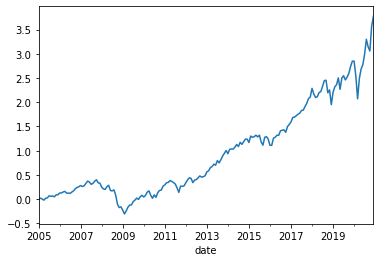

In [77]:
#Lets look at the cumulative returns
((Rmkt+1).cumprod()-1).plot()

**Things to try**

- Download the market factor from Kenfrench website. How correlated is our replication with his factor? Do they have similar mean and volatility in the same sample?
- Suppose you wanted to construct something "like" the SP500? I.e. do market cap weights but only form the 500 largest firms in a given month. How would you use groupby to do that?
- Suppose you lag 2 months instead of 1 does it make any difference?
- Suppose you drop the stocks with "negative" prices, does it make a difference?